## Import Library

In [17]:
# lstm_ks_lag.ipynb
# # %pip install mlflow
# %pip install xgboost

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


#

## Load Kaohsiung City

In [19]:
# 2. Load & aggregate Kaohsiung weekly data

# %%
df_raw = pd.read_csv("../data/3_df_merged_cleaned.csv")
df_raw["Date"] = pd.to_datetime(df_raw["Date"])

df_ks = df_raw[df_raw["City"] == "Kaohsiung City"].set_index("Date")

agg_dict = {
    "Cases": "sum",
    "Precip": "sum",
    "Pressure": "mean",
    "Tmean": "mean",
    "Tmin": "mean",
    "Tmax": "mean",
    "Humidity": "mean",
    "Windspeed": "mean",
    "BI": "mean",
    "HI": "mean",
    "CI": "mean",
    "PopDensity_km2": "mean",
}

df_weekly = df_ks.resample("W").agg(agg_dict)
df_weekly = df_weekly.asfreq("W")
df_weekly = df_weekly.interpolate(method="time").ffill().bfill()

In [20]:
# ---------- LAGS + TARGET ----------
df = df_weekly.copy()

# 1) columns to lag
lagged_cols = ["Cases", "Precip", "Tmean", "Humidity",
               "Windspeed", "BI", "HI", "CI"]

max_lag = 4

for col in lagged_cols:
    for lag in range(1, max_lag + 1):
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# 2) target in log-space
df["Cases_log"] = np.log1p(df["Cases"])

# 3) drop rows with NaNs from shifting
df = df.dropna()

# (optional) quick check
cols_to_show = ["Cases"] + [f"Cases_lag{i}" for i in range(1, max_lag+1)]
print(df[cols_to_show].head(10))



            Cases  Cases_lag1  Cases_lag2  Cases_lag3  Cases_lag4
Date                                                             
2010-01-31    4.0         6.0         6.0        10.0        11.0
2010-02-07    1.0         4.0         6.0         6.0        10.0
2010-02-14    1.0         1.0         4.0         6.0         6.0
2010-02-21    0.0         1.0         1.0         4.0         6.0
2010-02-28    0.0         0.0         1.0         1.0         4.0
2010-03-07    0.0         0.0         0.0         1.0         1.0
2010-03-14    1.0         0.0         0.0         0.0         1.0
2010-03-21    1.0         1.0         0.0         0.0         0.0
2010-03-28    0.0         1.0         1.0         0.0         0.0
2010-04-04    1.0         0.0         1.0         1.0         0.0


In [21]:
# 4. Train / Val / Test split

# %%
train_df = df.loc[df.index < "2022-01-01"]
test_df  = df.loc[df.index >= "2022-01-01"]

val_start = "2018-01-01"
train_inner_df = train_df.loc[train_df.index < val_start]
val_df         = train_df.loc[train_df.index >= val_start]

print("Train_inner:", train_inner_df.index.min(), "→", train_inner_df.index.max())
print("Val       :", val_df.index.min(), "→", val_df.index.max())
print("Test      :", test_df.index.min(),  "→", test_df.index.max())

Train_inner: 2010-01-31 00:00:00 → 2017-12-31 00:00:00
Val       : 2018-01-07 00:00:00 → 2021-12-26 00:00:00
Test      : 2022-01-02 00:00:00 → 2025-01-05 00:00:00


## Scale X and y

In [22]:
target_col = "Cases_log"
feature_cols = [c for c in df.columns if c != target_col]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_inner = scaler_X.fit_transform(train_inner_df[feature_cols])
X_val         = scaler_X.transform(val_df[feature_cols])
X_test        = scaler_X.transform(test_df[feature_cols])

y_train_inner = scaler_y.fit_transform(train_inner_df[[target_col]])
y_val         = scaler_y.transform(val_df[[target_col]])
y_test        = scaler_y.transform(test_df[[target_col]])


## BUild sequences

In [23]:
# 6. Build sequences for LSTM

# %%
def make_sequences(X, y, n_input):
    Xs, ys = [], []
    for i in range(len(X) - n_input):
        Xs.append(X[i : i + n_input])
        ys.append(y[i + n_input])
    return np.array(Xs), np.array(ys)

n_input = 24  # ~5 months of history

X_train_seq, y_train_seq = make_sequences(X_train_inner, y_train_inner, n_input)
X_val_seq,   y_val_seq   = make_sequences(X_val,         y_val,         n_input)
X_test_seq,  y_test_seq  = make_sequences(X_test,        y_test,        n_input)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val   seq:", X_val_seq.shape,   y_val_seq.shape)
print("Test  seq:", X_test_seq.shape,  y_test_seq.shape)

n_features = X_train_seq.shape[2]

Train seq: (390, 24, 44) (390, 1)
Val   seq: (184, 24, 44) (184, 1)
Test  seq: (134, 24, 44) (134, 1)


In [24]:
cols_to_show = ["Cases"] + [f"Cases_lag{i}" for i in range(1, max_lag+1)]
print(df[cols_to_show].head(10))


            Cases  Cases_lag1  Cases_lag2  Cases_lag3  Cases_lag4
Date                                                             
2010-01-31    4.0         6.0         6.0        10.0        11.0
2010-02-07    1.0         4.0         6.0         6.0        10.0
2010-02-14    1.0         1.0         4.0         6.0         6.0
2010-02-21    0.0         1.0         1.0         4.0         6.0
2010-02-28    0.0         0.0         1.0         1.0         4.0
2010-03-07    0.0         0.0         0.0         1.0         1.0
2010-03-14    1.0         0.0         0.0         0.0         1.0
2010-03-21    1.0         1.0         0.0         0.0         0.0
2010-03-28    0.0         1.0         1.0         0.0         0.0
2010-04-04    1.0         0.0         1.0         1.0         0.0


In [25]:
# 7. Build larger LSTM model

# %%
def build_lstm_model(n_input, n_features, lr=5e-4, dropout=0.1):
    model = Sequential()
    model.add(
        LSTM(
            128,
            return_sequences=True,
            input_shape=(n_input, n_features),
        )
    )
    model.add(LSTM(64))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(32, activation="relu"))   # new hidden layer
    model.add(Dense(1))                       # output


    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

model = build_lstm_model(n_input, n_features)
model.summary()


/opt/anaconda3/envs/dengue_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 128)        │        88,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,097 (547.25 KB)

 Trainable params: 140,097 (547.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# ---- Build sample weights for training sequences ----

cases = train_inner_df["Cases"].values  # original scale
cases_seq = cases[n_input:]             # same alignment as y_train_seq

weights = np.ones_like(cases_seq, dtype=float)

# small / early weeks
weights[cases_seq >= 10]  = 1    # still a bit more important

# medium outbreak (start of the rise)
weights[(cases_seq >= 50) & (cases_seq < 150)] = 8

# big outbreak
weights[cases_seq >= 150] = 3     # NOT 5.0

In [27]:
# 8. Train with EarlyStopping

# %%
es = EarlyStopping(
    monitor="val_loss",
    patience=30,
    restore_best_weights=True,
)

history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=120,
    batch_size=32,
    sample_weight=weights, 
    callbacks=[es],
    verbose=1,
    shuffle=False,
)

Epoch 1/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.9078 - val_loss: 1.8586
Epoch 2/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.9996 - val_loss: 1.1462
Epoch 3/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7132 - val_loss: 1.2312
Epoch 4/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5534 - val_loss: 1.2919
Epoch 5/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4945 - val_loss: 1.2874
Epoch 6/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4097 - val_loss: 1.3861
Epoch 7/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3567 - val_loss: 1.4880
Epoch 8/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3430 - val_loss: 1.6364
Epoch 9/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2694 - val_loss: 1.8960
Epoch 10/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2379 - val_loss: 2.0044
Epoch 11/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2599 - val_loss: 1.7916
Epoch 12/120
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

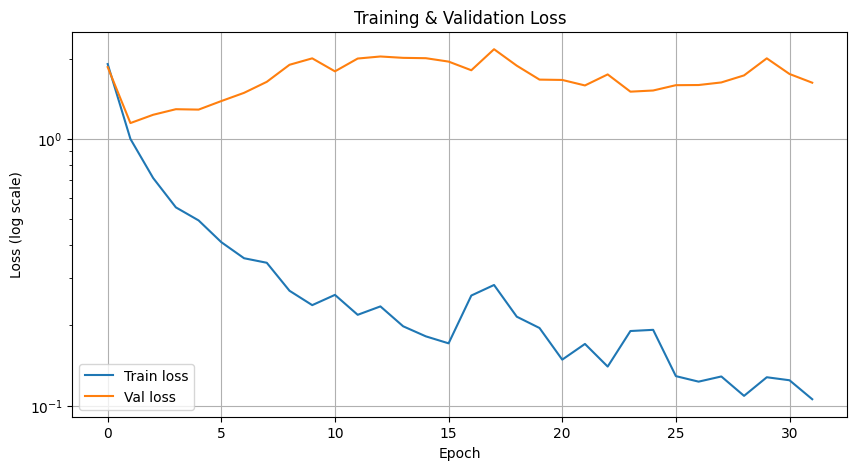

In [28]:
plt.figure(figsize=(10, 5))
plt.semilogy(history.history["loss"], label="Train loss")
plt.semilogy(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# 9. Evaluate on test set

# %%
y_pred_test_scaled = model.predict(X_test_seq)

# undo StandardScaler (still log space)
y_pred_test_log = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_log      = scaler_y.inverse_transform(y_test_seq)

# back to original cases
y_pred_test = np.expm1(y_pred_test_log).flatten()
y_test_real = np.expm1(y_test_log).flatten()

test_dates = test_df.index[n_input:]

mse  = mean_squared_error(y_test_real, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_real, y_pred_test)
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")

# %% [markdown]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
MSE  : 3006.390
RMSE : 54.831
MAE  : 20.005


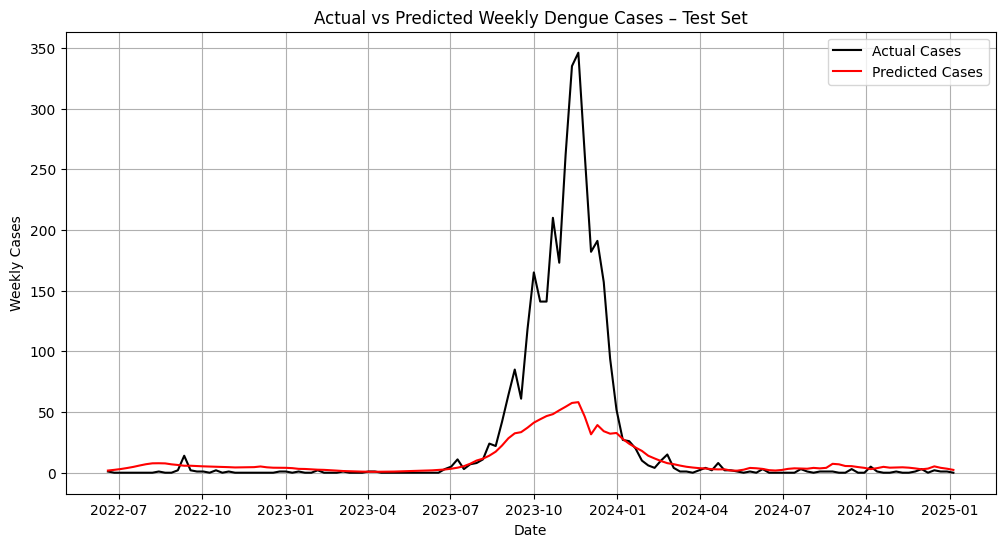

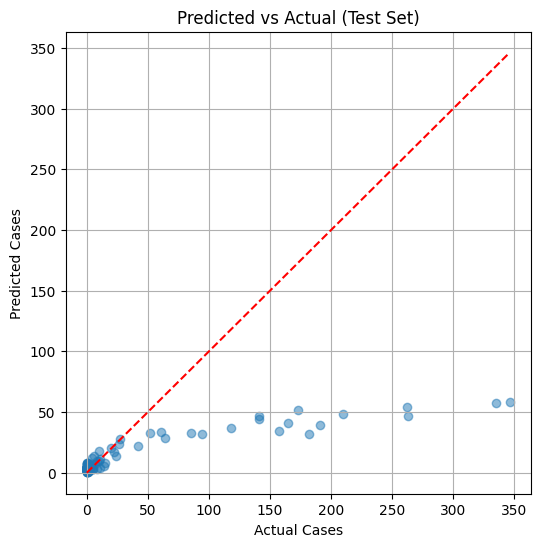

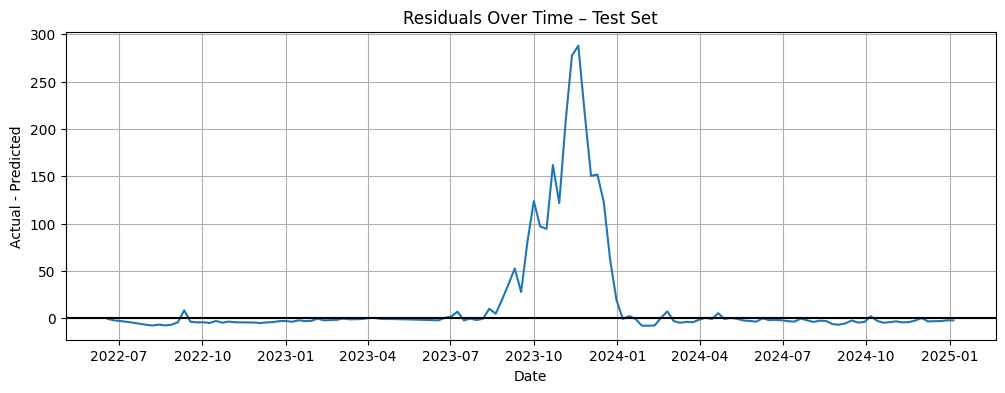

Mean residual (bias): 15.223926558423399


In [30]:
# 10. Plots

# %%
# Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_real, label="Actual Cases", color="black")
plt.plot(test_dates, y_pred_test, label="Predicted Cases", color="red")
plt.title("Actual vs Predicted Weekly Dengue Cases – Test Set")
plt.xlabel("Date")
plt.ylabel("Weekly Cases")
plt.legend()
plt.grid(True)
plt.show()

# Scatter
plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_pred_test, alpha=0.5)
max_val = max(y_test_real.max(), y_pred_test.max())
plt.plot([0, max_val], [0, max_val], "r--")
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Predicted vs Actual (Test Set)")
plt.grid(True)
plt.show()

# Residuals over time (Actual - Predicted)
residuals = y_test_real - y_pred_test
plt.figure(figsize=(12, 4))
plt.plot(test_dates, residuals)
plt.axhline(0, color="black")
plt.title("Residuals Over Time – Test Set")
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.grid(True)
plt.show()

print("Mean residual (bias):", residuals.mean())

In [31]:
print("Mean residual:", residuals.mean())
print("Mean residual (peak period only):",
      residuals[(test_dates >= "2023-06-01") & (test_dates <= "2024-02-01")].mean())


Mean residual: 15.223926558423399
Mean residual (peak period only): 66.14230839865549


In [32]:
# ======================================================
# 11. Save artifacts for Streamlit
# ======================================================
import os, json
from sklearn.metrics import r2_score

# Compute R² in original case scale
r2 = r2_score(y_test_real, y_pred_test)
print(f"R²   : {r2:.3f}")

# Make sure artifacts folder exists
os.makedirs("../artifacts", exist_ok=True)

city_code  = "ks"          # Kaohsiung
model_name = "lstm_lag"    # LSTM with lag features

# 1) Save test predictions (for plotting in Streamlit)
pred_df = pd.DataFrame({
    "Date": test_dates,       # weekly Date index (aligned with sequences)
    "y_test": y_test_real,
    "y_pred": y_pred_test
})
pred_path = f"../artifacts/{model_name}_{city_code}_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print("✅ Saved predictions to", pred_path)

# 2) Save evaluation metrics
metrics = {
    "MSE": float(mse),
    "RMSE": float(rmse),
    "MAE": float(mae),
    "R2": float(r2),
}
metrics_path = f"../artifacts/{model_name}_{city_code}_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print("✅ Saved metrics to", metrics_path)

# 3) (Optional) save residuals over time
resid_df = pd.DataFrame({
    "Date": test_dates,
    "residual": residuals
})
resid_path = f"../artifacts/{model_name}_{city_code}_residuals.csv"
resid_df.to_csv(resid_path, index=False)
print("✅ Saved residuals to", resid_path)

history_df = pd.DataFrame(history.history)
history_path = f"../artifacts/{model_name}_{city_code}_history.csv"
history_df.to_csv(history_path, index=False)

print("✅ Saved LSTM training history to", history_path)

R²   : 0.288
✅ Saved predictions to ../artifacts/lstm_lag_ks_predictions.csv
✅ Saved metrics to ../artifacts/lstm_lag_ks_metrics.json
✅ Saved residuals to ../artifacts/lstm_lag_ks_residuals.csv
✅ Saved LSTM training history to ../artifacts/lstm_lag_ks_history.csv
